# Haplotype analysis *Cyp6*

### Color palettes

In [1]:
# define dictionary of pop colors
pop_colours = {
 'Moshi' : "lightgreen",
 'Muleba' : "darkgreen",
}

dup_colours = {
    'Dup31 present' : 'mediumorchid',
    'Dup31 absent' : 'lightgray',
    'Dup33 present' : 'orchid',
    'Dup33 absent' : 'lightgray',
    '2 extra copies': 'purple',
    '1 extra copy': 'orange',
    'No CNV': 'lightgray'
}


### Import packages

In [2]:
import malariagen_data
import allel
import numpy as np
import pandas as pd
import re
import scipy.cluster
from scipy.stats import spearmanr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns



### Load CNV data

In [3]:
# Identify samples that have Cyp6_Dup31
disc_cnv_fn = '../Ag1000G_CNV_data/v3.7_1246-VO-TZ-KABULA-VMF00185/target_regions_analysis/focal_region_CNV_table_extras.csv'
discordant_read_calls = pd.read_csv(disc_cnv_fn, sep = '\t', index_col = 0)
has_Dup31 = discordant_read_calls['Cyp6aap_Dup31'].values
Dup31_calls = has_Dup31.astype('int')
has_Dup33 = discordant_read_calls['Cyp6aap_Dup33'].values
Dup33_calls = has_Dup33.astype('int')

# In order to known the copy number of each Dup specifically, we need to ignore samples that also
# have another CNV at Cyp6. Dup32 is always found with Dup31, so we consider them to be the same. 
other_cyp6_cnvs = (
    discordant_read_calls.columns.str.contains('Cyp6aap') &
    ~discordant_read_calls.columns.str.contains('Dup0') &
    ~discordant_read_calls.columns.str.contains('Dup31') &
    ~discordant_read_calls.columns.str.contains('Dup32') &
    ~discordant_read_calls.columns.str.contains('Dup33')
)
other_cyp6_calls = discordant_read_calls.loc[:, other_cyp6_cnvs]
has_other_cyp6_cnv = np.sum(other_cyp6_calls, 1).values > 0

# Now we can exclude samples that have both the focal and another CNV allele, or that have the 
# allele and are of high coverage variance (because we won't be able to assign copy number correctly)
exclude_samples_Dup31 = (  
    has_Dup31 & (
        has_Dup33 |
        has_other_cyp6_cnv | 
        discordant_read_calls["High.var.sample"]
    )                  
).values
exclude_samples_Dup33 = (  
    has_Dup33 & (
        has_Dup31 |
        has_other_cyp6_cnv | 
        discordant_read_calls["High.var.sample"]
    )                  
).values

Dup33_calls

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Load metadata

In [4]:
ag3 = malariagen_data.Ag3(pre=True)

sample_sets = ['1246-VO-TZ-KABULA-VMF00185']
meta = ag3.sample_metadata(sample_sets = sample_sets).set_index('sample_id')
meta['location'] = meta['location'].str.replace('_.*', '', regex=True)

# Make sure the samples are in the same order as the CNV data (they should be anyway, but 
# just in case)
meta = meta.loc[discordant_read_calls.index, :]

# Get haplotype-level metadata
hap_meta = pd.DataFrame(np.repeat(meta.values, 2, axis = 0))
hap_meta.columns = meta.columns
hap_meta.index = [np.repeat(meta.index, 2)[i] + ['a', 'b'][i%2] for i in range(len(hap_meta))]



Load sample metadata:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
hap_meta_Dup31 = hap_meta.loc[~np.repeat(exclude_samples_Dup31, 2), :]
hap_meta_Dup33 = hap_meta.loc[~np.repeat(exclude_samples_Dup33, 2), :]
hap_meta_Dup31

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,...,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter
VBS54893-6781STDY12150017a,EA18-0001,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
VBS54893-6781STDY12150017b,EA18-0001,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
VBS54894-6781STDY12150018a,EA18-0003,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
VBS54894-6781STDY12150018b,EA18-0003,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
VBS54895-6781STDY12150019a,EA18-0004,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Kilimanjaro,TZ-09,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBS55420-6781STDY12150539b,EA18-0573,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Kagera,TZ-05,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3
VBS55421-6781STDY12150540a,EA18-0575,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Kagera,TZ-05,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3
VBS55421-6781STDY12150540b,EA18-0575,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Kagera,TZ-05,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3
VBS55422-6781STDY12150541a,EA18-0576,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Kagera,TZ-05,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3


In [6]:
gene_copy_number = pd.read_csv('../Ag1000G_CNV_data/v3.7_1246-VO-TZ-KABULA-VMF00185/modal_CNVs/modal_copy_number_arabiensis.csv', sep = '\t', index_col = 0)

# Define genes of interest
cyp6_genes = dict(AGAP002862='Cyp6aa1')

# Select data for genes of interest, excluding samples with poor quality HMM data
cyp6_gene_copy_number = (
    gene_copy_number.loc[:, cyp6_genes.keys()]
    .rename(cyp6_genes, axis='columns')
)['Cyp6aa1'].values

Dup31_copy_number = cyp6_gene_copy_number[~exclude_samples_Dup31] * Dup31_calls[~exclude_samples_Dup31]
Dup33_copy_number = cyp6_gene_copy_number[~exclude_samples_Dup33] * Dup33_calls[~exclude_samples_Dup33]

display(pd.crosstab(meta.loc[~exclude_samples_Dup31, 'location'], Dup31_copy_number))
display(pd.crosstab(meta.loc[~exclude_samples_Dup33, 'location'], Dup33_copy_number))


col_0,0,1,2
location,,,
Moshi,181,19,13
Muleba,180,0,0


col_0,0,1,2,3
location,,,,
Moshi,66,60,73,1
Muleba,167,13,0,0


Nearly all samples have either 0, 1 or 2 extra copies.

Can we assume that we just have a simple duplication that is either het or hom?

Let's check Hardy_weinberg equilibrium under that assumption:


In [7]:
! echo "library('HardyWeinberg'); HWExact(c(181, 19, 13))" | R --vanilla 2>/dev/null | tail -n7
! echo -e "\n"
! echo "library('HardyWeinberg'); HWExact(c(66, 60, 74))" | R --vanilla 2>/dev/null | tail -n7
! echo -e "\n"
! echo "library('HardyWeinberg'); HWExact(c(167, 13, 0))" | R --vanilla 2>/dev/null | tail -n7


> library('HardyWeinberg'); HWExact(c(181, 19, 13))
Haldane Exact test for Hardy-Weinberg equilibrium (autosomal)
using SELOME p-value
sample counts: n =  181 n =  19 n =  13 
H0: HWE (D==0), H1: D <> 0 
D =  -10.62324 p-value =  0.000000001254795 
> 


> library('HardyWeinberg'); HWExact(c(66, 60, 74))
Haldane Exact test for Hardy-Weinberg equilibrium (autosomal)
using SELOME p-value
sample counts: n =  66 n =  60 n =  74 
H0: HWE (D==0), H1: D <> 0 
D =  -19.92 p-value =  0.00000001172853 
> 


> library('HardyWeinberg'); HWExact(c(167, 13, 0))
Haldane Exact test for Hardy-Weinberg equilibrium (autosomal)
using SELOME p-value
sample counts: n =  167 n =  13 n =  0 
H0: HWE (D==0), H1: D <> 0 
D =  0.2347222 p-value =  1 
> 


It's highly significantly divergent from expectations in Moshi. So in Muleba, it looks like Dup33 is single extra copy, but in Moshi it looks like both dups have a deficit of heterozygotes, suggesting that perhaps there is a two-copy version present as well. Other explanations are mis-calls (there definitely are occasional mistakes in copy-number estimation) and the fact that this is a resistance locus, and the nature of the GAARD bioassay protocol means that there will be a deficit of intermediate phenotypes, which might be CNV heterozygotes.  

### Load the haplotype data

In [8]:
region='2R:28250000-28750000'
haps = (
    ag3.haplotypes(region = region, 
                   analysis = 'arab', 
                   sample_sets = sample_sets)
    .set_index(samples = 'sample_id')
    .sel(samples = discordant_read_calls.index)
)

haps_Dup31 = haps.isel(samples = ~exclude_samples_Dup31)
haps_Dup33 = haps.isel(samples = ~exclude_samples_Dup33)

In [9]:
# Create haplotype array
hap_array_Dup31 = allel.GenotypeArray(haps_Dup31.call_genotype).to_haplotypes()

# Get allele counts
ac_Dup31 = hap_array_Dup31.count_alleles()

# Identify segregating non-singletons. 
non_singleton_Dup31 = ac_Dup31.min(1) > 1

# Filter the datasets, removing non-segregating and singleton variants 
haps_Dup31 = haps_Dup31.isel(variants = np.where(non_singleton_Dup31)[0])
hap_array_Dup31 = hap_array_Dup31[non_singleton_Dup31]

# Same again for Dup_33
hap_array_Dup33 = allel.GenotypeArray(haps_Dup33.call_genotype).to_haplotypes()
ac_Dup33 = hap_array_Dup33.count_alleles()
non_singleton_Dup33 = ac_Dup33.min(1) > 1
haps_Dup33 = haps_Dup33.isel(variants = np.where(non_singleton_Dup33)[0])
hap_array_Dup33 = hap_array_Dup33[non_singleton_Dup33]

hap_array_Dup31

<HaplotypeArray shape=(13857, 786) dtype=int8>
0 0 0 0 1 ... 0 0 0 0 0
1 1 1 1 0 ... 1 1 1 1 1
0 0 0 0 1 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [10]:
# Get the SNP genotypes coded as 0, 1, 2 (wt, het, homozygote mutant). Since all phased SNPs
# are biallelic, this is a suitable way to code genotype. 
genotypes_Dup31 = haps_Dup31.call_genotype.values.sum(2)
genotypes_Dup33 = haps_Dup33.call_genotype.values.sum(2)

genotypes_Dup31

array([[0, 0, 1, ..., 0, 0, 0],
       [2, 2, 1, ..., 2, 2, 2],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Identify proxy SNPs

In [11]:
# We look for SNPs whose presence / absence patterns are perfectly correlated with Dup31. 
SNP_cor_Dup31 = np.apply_along_axis(lambda x: spearmanr((x>0).astype('int'), 
                                                         Dup31_calls[~exclude_samples_Dup31]), 
                                    1, 
                                    genotypes_Dup31)[:, 0]
print(f'The maximum correlation coefficient with Dup31 is {np.nanmax(SNP_cor_Dup31)}')

/home/eric/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


The maximum correlation coefficient with Dup31 is 0.24021782527648247


In [12]:
# We look for SNPs whose presence / absence patterns are perfectly correlated with Dup33. 
SNP_cor_Dup33 = np.apply_along_axis(lambda x: spearmanr((x>0).astype('int'), 
                                                         Dup33_calls[~exclude_samples_Dup33]), 
                                    1, 
                                    genotypes_Dup33)[:, 0]
print(f'The maximum correlation coefficient with Dup33 is {np.nanmax(SNP_cor_Dup33)}')

The maximum correlation coefficient with Dup33 is 0.9227755865588156


In [13]:
# Let's look at the association of zygosity at those SNPs and Dup31 copy number. 
Dup31_proxy = genotypes_Dup31[np.nanargmax(SNP_cor_Dup31)]

print('Association of Dup31 proxy zygosity and Dup31 copy number in Moshi:')
display(
    pd.crosstab(Dup31_copy_number[(meta.loc[~exclude_samples_Dup31, :].location == 'Moshi').values],
                Dup31_proxy[(meta.loc[~exclude_samples_Dup31, :].location == 'Moshi').values])
)

print('Association of Dup31 proxy zygosity and Dup31 copy number in Muleba:')
display(
    pd.crosstab(Dup31_copy_number[(meta.loc[~exclude_samples_Dup31, :].location == 'Muleba').values],
                Dup31_proxy[(meta.loc[~exclude_samples_Dup31, :].location == 'Muleba').values])
)

Association of Dup31 proxy zygosity and Dup31 copy number in Moshi:


col_0,0,1
row_0,,
0,181,0
1,17,2
2,13,0


Association of Dup31 proxy zygosity and Dup31 copy number in Muleba:


col_0,0
row_0,
0,180


In [14]:
# Let's look at the association of zygosity at those SNPs and Dup33 copy number. 
Dup33_proxy = genotypes_Dup33[np.nanargmax(SNP_cor_Dup33)]

print('Association of Dup33 proxy zygosity and Dup33 copy number in Moshi:')
display(
    pd.crosstab(Dup33_copy_number[(meta.loc[~exclude_samples_Dup33, :].location == 'Moshi').values],
                Dup33_proxy[(meta.loc[~exclude_samples_Dup33, :].location == 'Moshi').values])
)

print('Association of Dup33 proxy zygosity and Dup33 copy number in Muleba:')
display(
    pd.crosstab(Dup33_copy_number[(meta.loc[~exclude_samples_Dup33, :].location == 'Muleba').values],
                Dup33_proxy[(meta.loc[~exclude_samples_Dup33, :].location == 'Muleba').values])
)

Association of Dup33 proxy zygosity and Dup33 copy number in Moshi:


col_0,0,1,2
row_0,,,
0,60,6,0
1,4,54,2
2,1,15,57
3,0,1,0


Association of Dup33 proxy zygosity and Dup33 copy number in Muleba:


col_0,0,1
row_0,,
0,164,3
1,1,12


So the proxy for Dup31 is useless, but for Dup33 it's fairly good.  

In [15]:
# Get the haplotypes rather than genotypes for the Dup proxies
Dup31_hap_proxy = hap_array_Dup31[np.nanargmax(SNP_cor_Dup31)]
Dup33_hap_proxy = hap_array_Dup33[np.nanargmax(SNP_cor_Dup33)]
Dup31_hap_proxy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Haplotype plotting functions

In [16]:
def find_clusters(dist, n, threshold=0.001, method='complete'):
        # build hierarchy
        clust = scipy.cluster.hierarchy.linkage(dist, method=method)
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(clust, threshold,
                                             criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        return clusters

# Some plotting functions
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

def plot_dendrogram(zhier, ax, h, method='complete', color_threshold=0, above_threshold_color='k'):

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(zhier, no_labels=True, count_sort=True,
                                           color_threshold=color_threshold,
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-.0001)

    ax.set_ylabel(r'$d_{xy}$')
    ax.autoscale(axis='x', tight=True)
    return r

def draw_hap_cluster_plot(z, r, h, 
                          pop_colour_scheme, cnv_colour_scheme, 
                          labels_for_pop_colours, labels_for_cnv_colours, 
                          cnv_name,
                          add_legend = True, title = '',
                          fn = None):

    gs = GridSpec(3, 1, height_ratios=[6.0, 0.5, 0.5])
    fig = plt.figure(figsize=(15, 5))

    plt.subplots_adjust(hspace=0.02)
    ax1 = plt.subplot(gs[0])
    sns.despine(ax=ax1, offset=5, bottom=True, top=True)
    _ = plot_dendrogram(z, ax1, h)
    ax1.spines['top'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylim(0)

    ax_pops = fig.add_subplot(gs[1])

    x_pop = labels_for_pop_colours.take(r['leaves'])
    hap_pop_clrs = [pop_colour_scheme[p] for p in x_pop]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                        yrange=(0, 1),
                        color=hap_pop_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')
    
    ax_cnv = fig.add_subplot(gs[2])

    x_cnv = labels_for_cnv_colours.take(r['leaves'])
    hap_cnv_clrs = [cnv_colour_scheme[p] for p in x_cnv]
    ax_cnv.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                       yrange=(0, 1),
                       color=hap_cnv_clrs);
    sns.despine(ax=ax_cnv, offset=5, left=True, bottom=True, top=True)

    ax_cnv.set_xticks([])
    ax_cnv.set_yticks([])
    ax_cnv.set_xlim(0, h.shape[1])
    ax_cnv.yaxis.set_label_position('left')
    ax_cnv.set_ylabel(cnv_name, rotation=0, ha='right', va='center')

    if add_legend:
        plot_x_range = ax1.get_xlim()[1] - ax1.get_xlim()[0]
        plot_y_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
        legend_x = ax1.get_xlim()[0] + plot_x_range * 0.95
            
        unique_label_cnv = np.unique(x_cnv)
        for i, k in enumerate(unique_label_cnv[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * i)
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = cnv_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)

        
        unique_label_pop = np.unique(x_pop)
        for j, k in enumerate(unique_label_pop[::-1]):
            legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + 0.1 * (i + 2 + j))
            ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = pop_colour_scheme[k]))
            ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)



    ax1.set_title(f'{title}')
    ax1.autoscale()
    fig.patch.set_alpha(1)
    
    if fn != None:
        ext = re.sub('.*\.', '', fn)
        plt.savefig(fn, format = ext)




### Haplotype clustering

In [17]:
# Home in on the 500 SNPs around the middle of Cyp6aa1
focal_pos = 28481606 # Middle of Cyp6aa1
window_size = 500  # Measured in SNPs


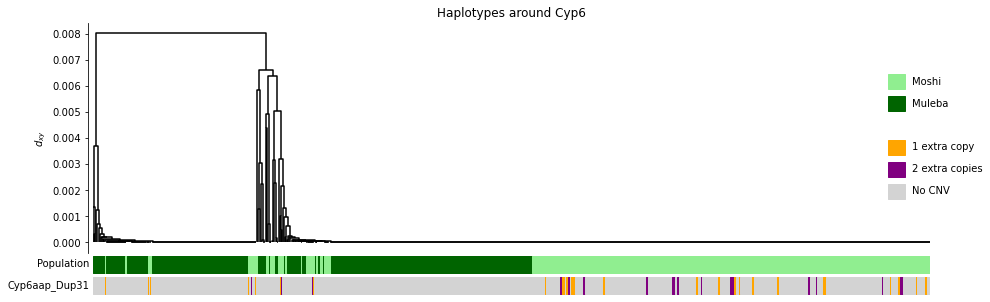

In [18]:
nearest_snp_index_Dup31 = np.argmin(np.abs(haps_Dup31.variant_position - focal_pos).values)
haptree_region_indices_Dup31 = range(nearest_snp_index_Dup31 - window_size//2, nearest_snp_index_Dup31 + window_size//2)
haptree_region_Dup31 = '2R:' + '-'.join(haps_Dup31.isel(variants = haptree_region_indices_Dup31).variant_position.values[[0,-1]].astype('str'))
loc_hap_Dup31 = hap_array_Dup31[haptree_region_indices_Dup31]
# loc_hap is the haplotype array for just those 500 SNPs. 

# Calculate the distance matrix 
dist = allel.pairwise_distance(loc_hap_Dup31, metric = 'hamming')
site_filter = ag3.snp_calls(region=haptree_region_Dup31, sample_sets="3.7")['variant_filter_pass_arab']
n_bases = np.sum(site_filter.values)
dist_dxy_Dup31 = dist * loc_hap_Dup31.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy_Dup31, method="complete")
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

# Now let's plot the haplotype clustering tree
Dup31_status = np.array(['No CNV', '1 extra copy', '2 extra copies'])[np.repeat(Dup31_copy_number, 2)]
draw_hap_cluster_plot(z, r, loc_hap_Dup31, 
                      pop_colour_scheme = pop_colours, 
                      cnv_colour_scheme = dup_colours,
                      labels_for_pop_colours = hap_meta_Dup31['location'], 
                      labels_for_cnv_colours = Dup31_status, 
                      cnv_name = 'Cyp6aap_Dup31',
                      title = 'Haplotypes around Cyp6',
                      fn = 'Cyp6_Dup31_haplotype_clustering.png'
)

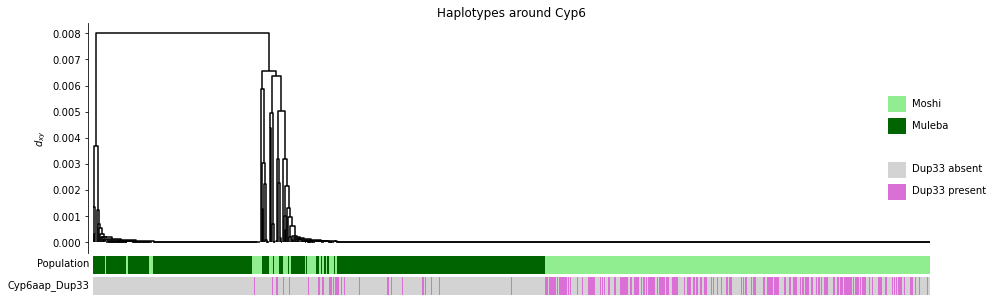

In [19]:
nearest_snp_index_Dup33 = np.argmin(np.abs(haps_Dup33.variant_position - focal_pos).values)
haptree_region_indices_Dup33 = range(nearest_snp_index_Dup33 - window_size//2, nearest_snp_index_Dup33 + window_size//2)
haptree_region_Dup33 = '2R:' + '-'.join(haps_Dup33.isel(variants = haptree_region_indices_Dup33).variant_position.values[[0,-1]].astype('str'))
loc_hap_Dup33 = hap_array_Dup33[haptree_region_indices_Dup33]
# loc_hap is the haplotype array for just those 500 SNPs. 

# Calculate the distance matrix 
dist = allel.pairwise_distance(loc_hap_Dup33, metric = 'hamming')
site_filter = ag3.snp_calls(region=haptree_region_Dup33, sample_sets="3.7")['variant_filter_pass_arab']
n_bases = np.sum(site_filter.values)
dist_dxy_Dup33 = dist * loc_hap_Dup33.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy_Dup33, method="complete")
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

# Now let's plot the haplotype clustering tree
Dup33_hap_status = np.array(['Dup33 absent', 'Dup33 present'])[Dup33_hap_proxy]
draw_hap_cluster_plot(z, r, loc_hap_Dup33, 
                      pop_colour_scheme = pop_colours, 
                      cnv_colour_scheme = dup_colours,
                      labels_for_pop_colours = hap_meta_Dup33['location'], 
                      labels_for_cnv_colours = Dup33_hap_status, 
                      cnv_name = 'Cyp6aap_Dup33',
                      title = 'Haplotypes around Cyp6',
                      fn = 'Cyp6_Dup33_haplotype_clustering.png'
)

In [20]:
# Instead of labelling by region, label by phenotype
phen = pd.read_csv('../../data/sample_phenotypes_EA.csv', sep = '\t', index_col = 'specimen')
phen

,species,location,country,insecticide,concentration,exposure_time,phenotype,plate
specimen,,,,,,,,
EA18-0001,arabiensis,Moshi,Tanzania,Delta,0.5,60,dead,TZ18_Plate03
EA18-0002,arabiensis,Moshi,Tanzania,Delta,0.5,60,dead,TZ18_Plate03
EA18-0003,arabiensis,Moshi,Tanzania,Delta,0.5,60,dead,TZ18_Plate03
EA18-0004,arabiensis,Moshi,Tanzania,Delta,0.5,60,dead,TZ18_Plate03
EA18-0005,arabiensis,Moshi,Tanzania,Delta,0.5,60,dead,TZ18_Plate03
...,...,...,...,...,...,...,...,...
EA18-1095,arabiensis,Bondo,Kenya,Delta,2.0,60,alive,KN18_Plate06
EA18-1096,arabiensis,Bondo,Kenya,Delta,2.0,60,alive,KN18_Plate06
EA18-1097,arabiensis,Bondo,Kenya,Delta,2.0,60,alive,KN18_Plate06


In [21]:
hap_meta_Dup31['insecticide'] = phen.loc[hap_meta_Dup31['partner_sample_id'], ['insecticide']].values
hap_meta_Dup31['phenotype'] = phen.loc[hap_meta_Dup31['partner_sample_id'], ['phenotype']].values
hap_meta_Dup33['insecticide'] = phen.loc[hap_meta_Dup33['partner_sample_id'], ['insecticide']].values
hap_meta_Dup33['phenotype'] = phen.loc[hap_meta_Dup33['partner_sample_id'], ['phenotype']].values
hap_meta_Dup33

/tmp/ipykernel_322146/1741616787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hap_meta_Dup31['insecticide'] = phen.loc[hap_meta_Dup31['partner_sample_id'], ['insecticide']].values
/tmp/ipykernel_322146/1741616787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hap_meta_Dup31['phenotype'] = phen.loc[hap_meta_Dup31['partner_sample_id'], ['phenotype']].values
/tmp/ipykernel_322146/1741616787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,...,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter,insecticide,phenotype
VBS54893-6781STDY12150017a,EA18-0001,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3,Delta,dead
VBS54893-6781STDY12150017b,EA18-0001,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3,Delta,dead
VBS54894-6781STDY12150018a,EA18-0003,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3,Delta,dead
VBS54894-6781STDY12150018b,EA18-0003,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3,Delta,dead
VBS54895-6781STDY12150019a,EA18-0004,Martin Donnelly; David Weetman,Tanzania,Moshi,2018,7,-3.384,37.349,F,1246-VO-TZ-KABULA-VMF00185,...,Moshi Urban,arabiensis,TZ-09_arab_2018,TZ-09_arab_2018_07,TZ-09_arab_2018_Q3,TZ-09_Moshi-Urban_arab_2018,TZ-09_Moshi-Urban_arab_2018_07,TZ-09_Moshi-Urban_arab_2018_Q3,Delta,dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBS55420-6781STDY12150539b,EA18-0573,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3,Delta,alive
VBS55421-6781STDY12150540a,EA18-0575,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3,Delta,alive
VBS55421-6781STDY12150540b,EA18-0575,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3,Delta,alive
VBS55422-6781STDY12150541a,EA18-0576,Martin Donnelly; David Weetman,Tanzania,Muleba,2018,7,-2.092,31.574,F,1246-VO-TZ-KABULA-VMF00185,...,Muleba,arabiensis,TZ-05_arab_2018,TZ-05_arab_2018_07,TZ-05_arab_2018_Q3,TZ-05_Muleba_arab_2018,TZ-05_Muleba_arab_2018_07,TZ-05_Muleba_arab_2018_Q3,Delta,alive


In [22]:
which_delta_Dup31 = hap_meta_Dup31['insecticide'] == 'Delta'
which_delta_Dup33 = hap_meta_Dup33['insecticide'] == 'Delta'
hap_meta_Dup31_delta = hap_meta_Dup31.loc[which_delta_Dup31, :]
hap_meta_Dup33_delta = hap_meta_Dup33.loc[which_delta_Dup33, :]

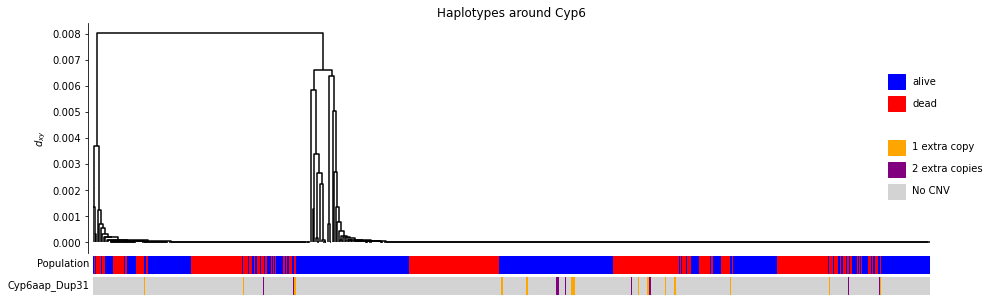

In [23]:
phen_colours = {
 'dead' : "red",
 'alive' : "blue",
}

# Calculate the distance matrix 
loc_hap_Dup31_delta = loc_hap_Dup31[:, which_delta_Dup31]
dist = allel.pairwise_distance(loc_hap_Dup31_delta, metric = 'hamming')
site_filter = ag3.snp_calls(region=haptree_region_Dup31, sample_sets="3.7")['variant_filter_pass_arab']
n_bases = np.sum(site_filter.values)
dist_dxy_Dup31 = dist * loc_hap_Dup31_delta.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy_Dup31, method="complete")
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

# Now let's plot the haplotype clustering tree
Dup31_status = np.array(['No CNV', '1 extra copy', '2 extra copies'])[np.repeat(Dup31_copy_number, 2)[which_delta_Dup31]]
draw_hap_cluster_plot(z, r, loc_hap_Dup31, 
                      pop_colour_scheme = phen_colours, 
                      cnv_colour_scheme = dup_colours,
                      labels_for_pop_colours = hap_meta_Dup31_delta['phenotype'], 
                      labels_for_cnv_colours = Dup31_status, 
                      cnv_name = 'Cyp6aap_Dup31',
                      title = 'Haplotypes around Cyp6',
                      fn = 'Cyp6_Dup31_haplotype_clustering_phenotype.png'
)

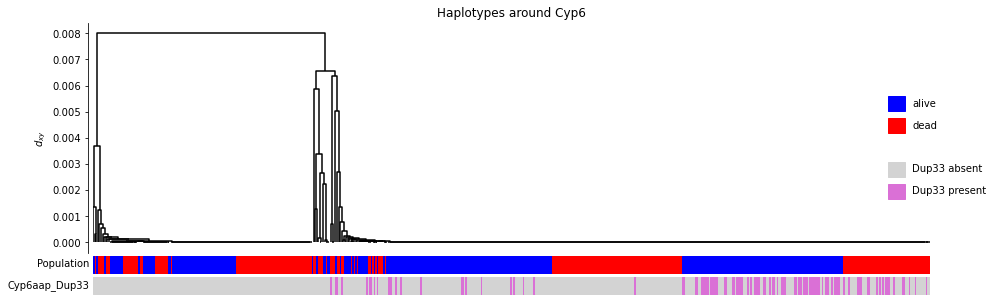

In [24]:

# Calculate the distance matrix 
loc_hap_Dup33_delta = loc_hap_Dup33[:, which_delta_Dup33]
dist = allel.pairwise_distance(loc_hap_Dup33_delta, metric = 'hamming')
site_filter = ag3.snp_calls(region=haptree_region_Dup33, sample_sets="3.7")['variant_filter_pass_arab']
n_bases = np.sum(site_filter.values)
dist_dxy_Dup33 = dist * loc_hap_Dup33_delta.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy_Dup33, method="complete")
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

# Now let's plot the haplotype clustering tree
Dup33_hap_status = np.array(['Dup33 absent', 'Dup33 present'])[Dup33_hap_proxy[which_delta_Dup33]]
draw_hap_cluster_plot(z, r, loc_hap_Dup33_delta, 
                      pop_colour_scheme = phen_colours, 
                      cnv_colour_scheme = dup_colours,
                      labels_for_pop_colours = hap_meta_Dup33_delta['phenotype'], 
                      labels_for_cnv_colours = Dup33_hap_status, 
                      cnv_name = 'Cyp6aap_Dup33',
                      title = 'Haplotypes around Cyp6',
                      fn = 'Cyp6_Dup33_haplotype_clustering_phenotype.png'
)